In [9]:
from src.pipelines.ingestion_pipeline import run_ingestion
from src.pipelines.preprocessing_pipeline import run_preprocessing
from src.pipelines.feature_pipeline import run_feature_engineering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_auc_score, accuracy_score, roc_curve,
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay
)


In [ ]:
results_table = pd.DataFrame(columns=[
    'model_name', 'train_auc', 'test_auc',
    'best_threshold_acc', 'train_accuracy', 'test_accuracy',
    'best_threshold_f1', 'precision', 'sensitivity', 'f1_score'
])

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test, results_df=None):
    if results_df is None:
        results_df = results_table.copy()

    X_train = np.asarray(X_train, dtype=np.float32)
    X_test = np.asarray(X_test, dtype=np.float32)
    y_train = np.asarray(y_train, dtype=np.float32)
    y_test = np.asarray(y_test, dtype=np.float32)

    if model_name == 'NN_model':
        print('NN')
    else:
        model.fit(X_train, y_train)

    if hasattr(model, "predict_proba"):
        y_train_pred = model.predict_proba(X_train)[:, 1]
        y_test_pred = model.predict_proba(X_test)[:, 1]
    else:
        y_train_pred = model.predict(X_train).flatten()
        y_test_pred = model.predict(X_test).flatten()

    print('y_train')
    print(np.isnan(y_train).any())
    print('y_trai_pred')
    print(np.isnan(y_train_pred).any())
    train_auc = roc_auc_score(y_train, y_train_pred)

    test_auc = roc_auc_score(y_test, y_test_pred)

    thresholds = np.linspace(0, 1, 250)
    train_accs = [accuracy_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_acc = thresholds[np.argmax(train_accs)]
    train_acc = max(train_accs)
    test_acc = accuracy_score(y_test, y_test_pred >= best_threshold_acc)

    f1_scores = [f1_score(y_train, y_train_pred >= t) for t in thresholds]
    best_threshold_f1 = thresholds[np.argmax(f1_scores)]

    y_test_bin_f1 = (y_test_pred >= best_threshold_f1).astype(int)
    precision = precision_score(y_test, y_test_bin_f1)
    recall = recall_score(y_test, y_test_bin_f1)
    f1 = f1_score(y_test, y_test_bin_f1)

    result_row = pd.DataFrame([{
        'model_name': model_name,
        'train_auc': round(train_auc, 4),
        'test_auc': round(test_auc, 4),
        'best_threshold_acc': round(best_threshold_acc, 4),
        'train_accuracy': round(train_acc, 4),
        'test_accuracy': round(test_acc, 4),
        'best_threshold_f1': round(best_threshold_f1, 4),
        'precision': round(precision, 4),
        'sensitivity': round(recall, 4),
        'f1_score': round(f1, 4)
    }])

    results_df = pd.concat([results_df, result_row], ignore_index=True)

    print(f"\n✅ Evaluation for {model_name}")
    print(f"AUC - Train: {train_auc:.4f}, Test: {test_auc:.4f}")
    print(f"Best Accuracy Threshold: {best_threshold_acc:.2f} | Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Best F1 Threshold: {best_threshold_f1:.2f} | Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr_train, tpr_train, label=f"Train ROC (AUC = {train_auc:.2f})")
    plt.plot(fpr_test, tpr_test, label=f"Test ROC (AUC = {test_auc:.2f})", linestyle='--')
    plt.plot([0, 1], [0, 1], linestyle=':', color='grey')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {model_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    cm = confusion_matrix(y_test, y_test_bin_f1)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name} (Threshold: {best_threshold_f1:.2f})")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    sns.histplot(y_train_pred[y_train == 0], bins=50, color='blue', label='Class 0', stat='density', kde=True)
    sns.histplot(y_train_pred[y_train == 1], bins=50, color='red', label='Class 1', stat='density', kde=True)
    plt.axvline(best_threshold_f1, color='black', linestyle='--', label=f"Best F1 Threshold = {best_threshold_f1:.2f}")
    plt.title(f"Train Set: Predicted Probability Distribution - {model_name}")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

In [ ]:

raw_df = run_ingestion(data_dir='../Data', output_path='../Data/raw_data.parquet')
print(f"Ingested {len(raw_df)} rows of raw data.")


Ingested 500000 rows of raw data.


In [15]:

processed_df = run_preprocessing(
    raw_data_path='../Data/raw_data.parquet',
    output_path='../Data/processed_data.parquet'
)
print(f"Preprocessed {len(raw_df)} rows of raw data.")

Preprocessed 500000 rows of raw data.


In [16]:
processed_df.head()

,transaction_id,timestamp,user_id,merchant_id,amount,channel,currency,device,location,payment_method,...,distance_km,speed_kmph,amount/avg_amount,amount/sum_monthly_installments,amount/sum_monthly_expenses,country_u=t,country_m=t,countries_same,within_10pct,within_5pct
197951,TX197951,2022-01-08 16:48:00,U00001,M0245,32.24,online,EUR,Android,"{'lat': 54.710715, 'long': 15.368695}",mobile_payment,...,1994.074291,295.418413,0.163298,0.067491,0.132577,False,False,0,0.0,0.0
187979,TX187979,2022-01-12 16:23:00,U00001,M0332,4.29,in-store,EUR,Android,"{'lat': 58.897717, 'long': 30.25543}",debit_card,...,1016.169374,10.631611,0.23366,0.008981,0.017641,False,False,0,0.0,0.0
137034,TX137034,2022-01-18 10:40:00,U00001,M0331,67.0,in-store,EUR,iOS,"{'lat': 42.684202, 'long': 3.843828}",debit_card,...,2556.977104,18.491301,0.540715,0.140258,0.275516,False,False,0,0.0,0.0
401318,TX401318,2022-07-18 08:05:00,U00001,M0971,3.59,in-store,EUR,Web,"{'lat': 44.296089, 'long': 15.749937}",mobile_payment,...,976.612531,0.224952,3.663265,0.007515,0.014763,False,False,0,0.0,0.0
95555,TX095555,2022-08-09 12:30:00,U00001,M0598,22.94,online,EUR,iOS,"{'lat': 46.209657, 'long': 28.773734}",credit_card,...,1039.774561,1.952922,1.082586,0.048023,0.094333,False,False,0,0.0,0.0


In [17]:
print(list(processed_df.columns.values))

['transaction_id', 'timestamp', 'user_id', 'merchant_id', 'amount', 'channel', 'currency', 'device', 'location', 'payment_method', 'is_international', 'session_length_seconds', 'is_first_time_merchant', 'is_fraud', 'category', 'country_merchant', 'trust_score', 'number_of_alerts_last_6_months', 'avg_transaction_amount', 'account_age_months', 'has_fraud_history', 'age', 'sex', 'education', 'primary_source_of_income', 'sum_of_monthly_installments', 'sum_of_monthly_expenses', 'country_users', 'signup_date', 'risk_score', 'transaction_country', 'is_country_nan', 'country_merchant_distance_centroid', 'country_user_distance_centroid', 'country_merchant_distance_centroid_w', 'country_user_distance_centroid_w', 'Month_Year_EOM', 'Date', 'Year', 'hour', 'part_of_day', 'time_diff', 'time_diff_hours', 'latitude', 'longitude', 'lat_prev', 'lon_prev', 'time_prev', 'distance_km', 'speed_kmph', 'amount/avg_amount', 'amount/sum_monthly_installments', 'amount/sum_monthly_expenses', 'country_u=t', 'coun

In [18]:
prepare_kwargs = dict(
    to_drop=['transaction_id', 'user_id', 'currency', 'location'],
    to_think_but_drop=['signup_date','Month_Year_EOM','Date','Year','time_diff','time_prev',
                       'latitude','longitude','lat_prev','lon_prev'],
    to_categorize=['channel','device','payment_method','category','country_merchant','sex',
                   'education','primary_source_of_income','country_users','part_of_day','transaction_country'],
    cutoff="2023-07-01",
    target="is_fraud",
)

X_train, y_train, X_test, y_test = run_feature_engineering(
    processed_data_path="../data/processed_data.parquet",
    X_train_path="../data/X_train.parquet",
    X_test_path ="../data/X_test.parquet",
    y_train_path="../data/y_train.parquet",
    y_test_path ="../data/y_test.parquet",
    **prepare_kwargs
)

In [19]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import StratifiedKFold



In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_weight=1,
    scale_pos_weight=scale_pos_weight,
    verbosity=0,
    random_state=42
)

# Run cross-validation summary
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, xgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
    
    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6113, Validation AUC: 0.5844
Fold 2 - Train AUC: 0.6114, Validation AUC: 0.5819
Fold 3 - Train AUC: 0.6117, Validation AUC: 0.5841
Fold 4 - Train AUC: 0.6114, Validation AUC: 0.5866
Fold 5 - Train AUC: 0.6118, Validation AUC: 0.5803

Average Train AUC: 0.6115
Average Validation AUC: 0.5834


y_train
False
y_trai_pred
False


C:\Users\Jan\AppData\Local\Temp\ipykernel_18640\3494301503.py:75: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, result_row], ignore_index=True)



✅ Evaluation for XGBoost
AUC - Train: 0.6072, Test: 0.5820
Best Accuracy Threshold: 0.73 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.53 | Precision: 0.1091, Recall: 0.4524, F1: 0.1758


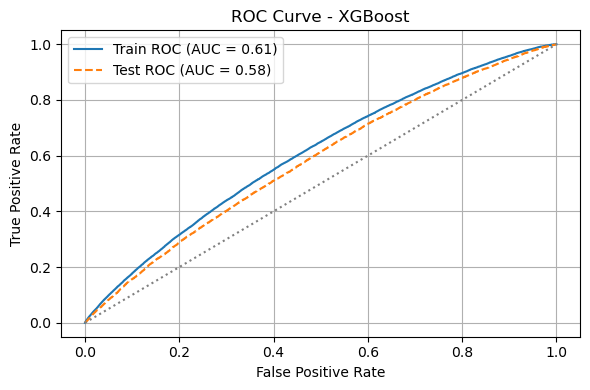

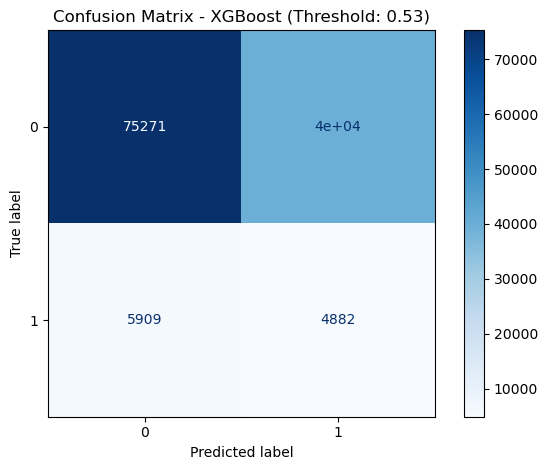

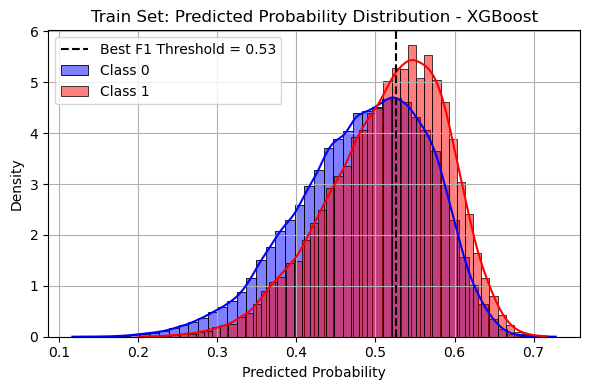

In [21]:
results_table = evaluate_model(xgb_model, "XGBoost", X_train, y_train, X_test, y_test, results_df=results_table)

In [ ]:
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

lgb_model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.1,
    max_depth=3,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=10,
    min_child_samples=20,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

# 5 fold Cross-Validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    lgb_model.fit(X_tr, y_tr)
    tr_auc = roc_auc_score(y_tr, lgb_model.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, lgb_model.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


Fold 1 - Train AUC: 0.6117, Validation AUC: 0.5857
Fold 2 - Train AUC: 0.6118, Validation AUC: 0.5828
Fold 3 - Train AUC: 0.6118, Validation AUC: 0.5838
Fold 4 - Train AUC: 0.6109, Validation AUC: 0.5856
Fold 5 - Train AUC: 0.6112, Validation AUC: 0.5814

Average Train AUC: 0.6115
Average Validation AUC: 0.5838


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


y_train
False
y_trai_pred
False

✅ Evaluation for LGB
AUC - Train: 0.6066, Test: 0.5824
Best Accuracy Threshold: 0.72 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1091, Recall: 0.4787, F1: 0.1777


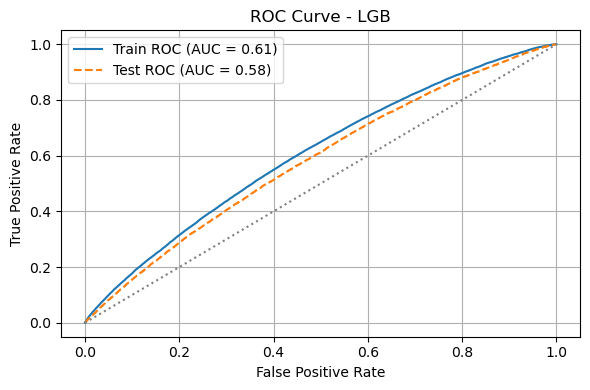

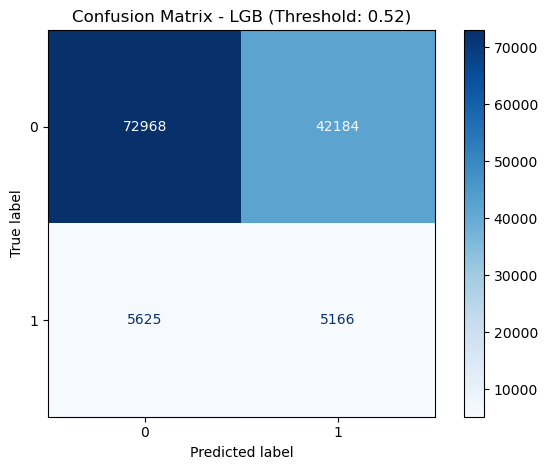

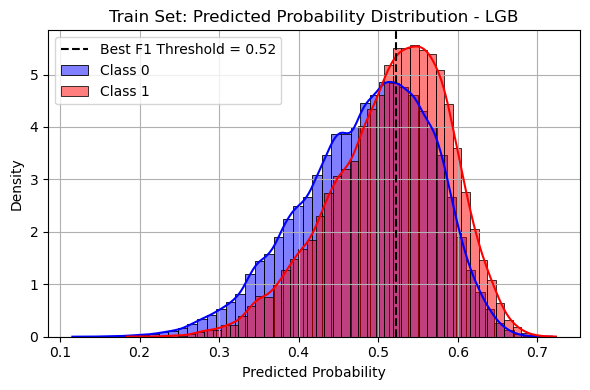

In [24]:
results_table = evaluate_model(lgb_model, "LGB", X_train, y_train, X_test, y_test, results_df=results_table)

In [25]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

pos = np.sum(y_train == 1)
neg = np.sum(y_train == 0)
scale_pos_weight = neg / pos

catboost_model = CatBoostClassifier(
    iterations=150,
    learning_rate=0.05,          
    depth=4,                     
    l2_leaf_reg=10,              
    bagging_temperature=1.0,     
    scale_pos_weight=scale_pos_weight,
    verbose=0,
    random_seed=42,
    eval_metric='AUC',
    thread_count=-1
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    catboost_model.fit(X_tr, y_tr)
    y_tr_pred = catboost_model.predict_proba(X_tr)[:, 1]
    y_val_pred = catboost_model.predict_proba(X_val)[:, 1]

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:", np.mean(train_aucs).round(4))
print("Average Validation AUC:", np.mean(val_aucs).round(4))


Fold 1 - Train AUC: 0.5936, Validation AUC: 0.5888
Fold 2 - Train AUC: 0.5943, Validation AUC: 0.5851
Fold 3 - Train AUC: 0.5938, Validation AUC: 0.5888
Fold 4 - Train AUC: 0.5934, Validation AUC: 0.5896
Fold 5 - Train AUC: 0.5945, Validation AUC: 0.5846

Average Train AUC: 0.5939
Average Validation AUC: 0.5874


y_train
False
y_trai_pred
False

✅ Evaluation for CatBoost
AUC - Train: 0.5928, Test: 0.5857
Best Accuracy Threshold: 0.66 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.52 | Precision: 0.1087, Recall: 0.5029, F1: 0.1788


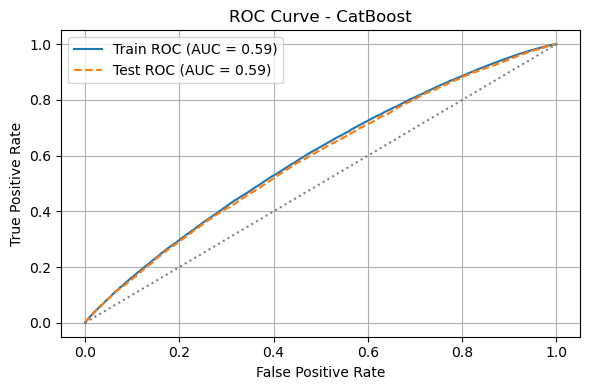

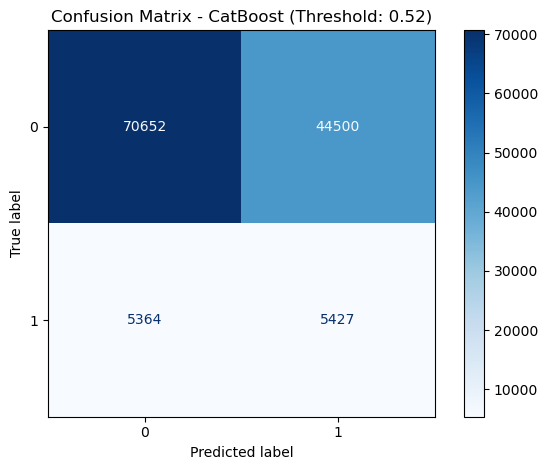

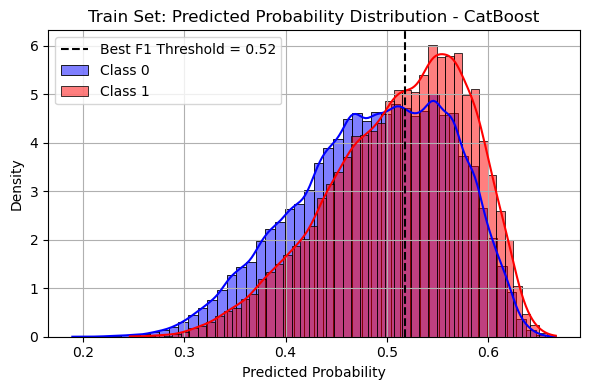

In [27]:
results_table = evaluate_model(catboost_model, "CatBoost", X_train, y_train, X_test, y_test, results_df=results_table)


📂 Fold 1


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - auc: 0.5033 - loss: 0.5327 - val_auc: 0.5028 - val_loss: 0.2915 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - auc: 0.5134 - loss: 0.3018 - val_auc: 0.5652 - val_loss: 0.2888 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.5252 - loss: 0.2973 - val_auc: 0.5808 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.5407 - loss: 0.2932 - val_auc: 0.5836 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - auc: 0.5486 - loss: 0.2880 - val_auc: 0.5836 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - auc: 0.5593 - loss: 0.2894 - val_auc: 0.5837 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 7/200
1037/1044 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - auc: 0.5761 - loss: 0.2881
Epoch 7: ReduceLROnPlateau reducing learning r

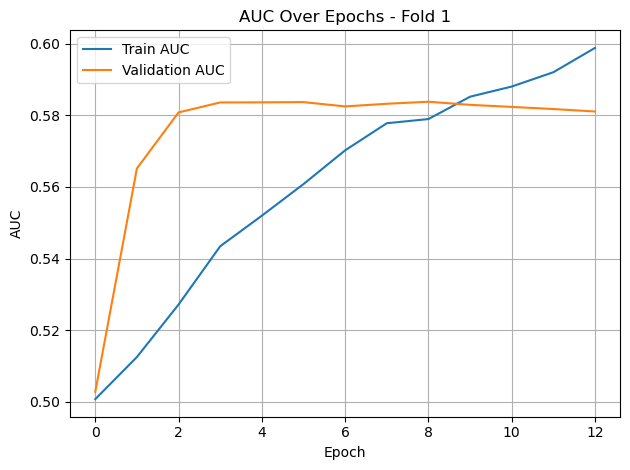


📂 Fold 2


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - auc: 0.5027 - loss: 0.5289 - val_auc: 0.5016 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.5035 - loss: 0.3050 - val_auc: 0.5387 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - auc: 0.5109 - loss: 0.2977 - val_auc: 0.5749 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5349 - loss: 0.2949 - val_auc: 0.5798 - val_loss: 0.2867 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5492 - loss: 0.2884 - val_auc: 0.5805 - val_loss: 0.2865 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc: 0.5604 - loss: 0.2906 - val_auc: 0.5815 - val_loss: 0.2863 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5674 - loss: 0.2874 - val_auc: 0.5811 - val_loss: 0.2862 - learni

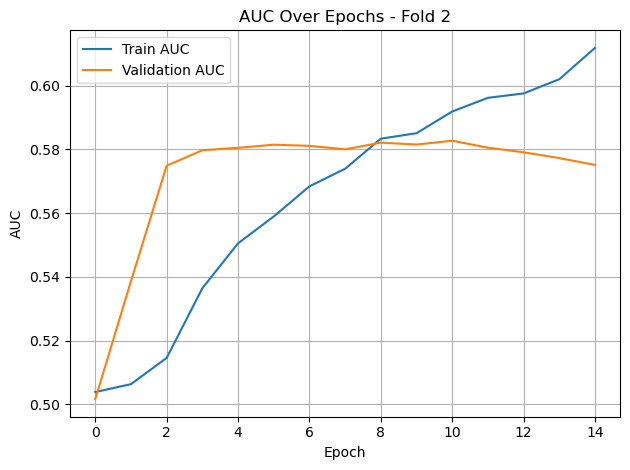


📂 Fold 3


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - auc: 0.5013 - loss: 0.5284 - val_auc: 0.5204 - val_loss: 0.2923 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5066 - loss: 0.3051 - val_auc: 0.5572 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.5155 - loss: 0.2983 - val_auc: 0.5762 - val_loss: 0.2874 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - auc: 0.5310 - loss: 0.2929 - val_auc: 0.5803 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5511 - loss: 0.2907 - val_auc: 0.5844 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5515 - loss: 0.2913 - val_auc: 0.5843 - val_loss: 0.2860 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - auc: 0.5652 - loss: 0.2884 - val_auc: 0.5843 - val_loss: 0.2860 - learnin

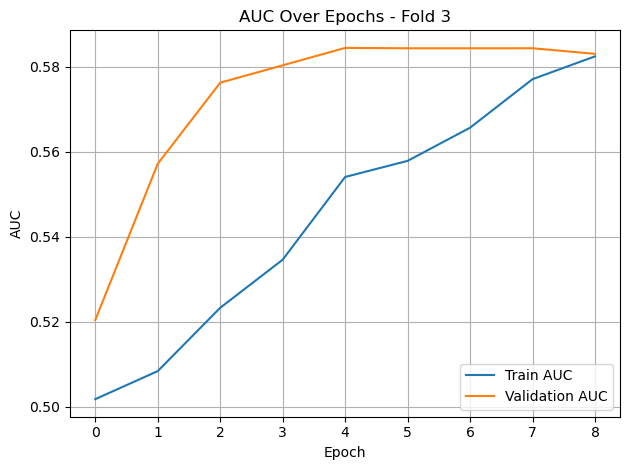


📂 Fold 4


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - auc: 0.4970 - loss: 0.5540 - val_auc: 0.5230 - val_loss: 0.2938 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - auc: 0.5061 - loss: 0.3092 - val_auc: 0.5629 - val_loss: 0.2893 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5225 - loss: 0.2965 - val_auc: 0.5771 - val_loss: 0.2871 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5435 - loss: 0.2938 - val_auc: 0.5794 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5462 - loss: 0.2900 - val_auc: 0.5814 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - auc: 0.5602 - loss: 0.2906 - val_auc: 0.5822 - val_loss: 0.2861 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - auc: 0.5698 - loss: 0.2884 - val_auc: 0.5825 - val_loss: 0.2861 - learni

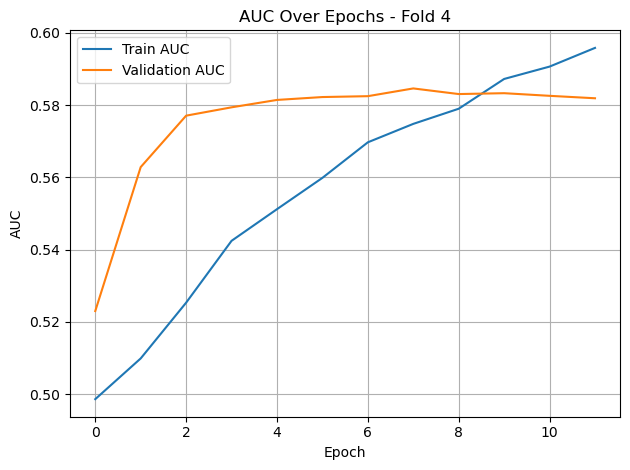


📂 Fold 5
Epoch 1/200


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc: 0.5005 - loss: 0.5522 - val_auc: 0.5085 - val_loss: 0.2939 - learning_rate: 0.0010
Epoch 2/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5091 - loss: 0.3027 - val_auc: 0.5441 - val_loss: 0.2916 - learning_rate: 0.0010
Epoch 3/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - auc: 0.5145 - loss: 0.3004 - val_auc: 0.5732 - val_loss: 0.2881 - learning_rate: 0.0010
Epoch 4/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5375 - loss: 0.2938 - val_auc: 0.5793 - val_loss: 0.2868 - learning_rate: 0.0010
Epoch 5/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5556 - loss: 0.2897 - val_auc: 0.5783 - val_loss: 0.2866 - learning_rate: 0.0010
Epoch 6/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - auc: 0.5551 - loss: 0.2894 - val_auc: 0.5782 - val_loss: 0.2864 - learning_rate: 0.0010
Epoch 7/200
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5682 - loss: 0.2860 - val_auc: 0.5801 - val_loss: 0.2864 - learning_rate: 0.00

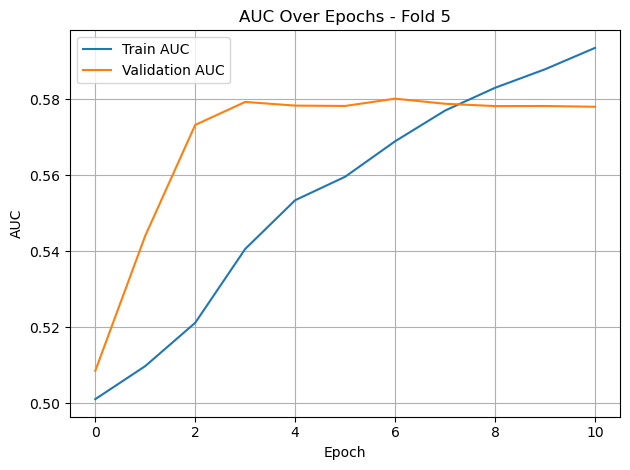


📊 Final Results:
Average Train AUC: 0.6051
Average Validation AUC: 0.5834

📦 Evaluating final NN model on full dataset


c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - auc: 0.5022 - loss: 0.5137 - val_auc: 0.4990 - val_loss: 0.2961 - learning_rate: 0.0010
Epoch 2/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5022 - loss: 0.3038 - val_auc: 0.5173 - val_loss: 0.2931 - learning_rate: 0.0010
Epoch 3/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5116 - loss: 0.2959 - val_auc: 0.5492 - val_loss: 0.2907 - learning_rate: 0.0010
Epoch 4/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5291 - loss: 0.2900 - val_auc: 0.5657 - val_loss: 0.2899 - learning_rate: 0.0010
Epoch 5/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5447 - loss: 0.2893 - val_auc: 0.5785 - val_loss: 0.2895 - learning_rate: 0.0010
Epoch 6/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5636 - loss: 0.2886 - val_auc: 0.5793 - val_loss: 0.2894 - learning_rate: 0.0010
Epoch 7/200
1305/1305 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc: 0.5688 - loss: 0.2879 - val_auc: 0.5804 - val_loss: 0.2893 - learnin

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.metrics import AUC

def create_nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim=input_dim))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    adam_optimizer = Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-7,
        amsgrad=False
    )

    model.compile(optimizer=adam_optimizer, 
                  loss='binary_crossentropy', 
                  metrics=[AUC(name='auc')])
    return model

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    print(f"\n📂 Fold {fold}")
    
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    imputer = SimpleImputer(strategy='mean')
    X_tr = pd.DataFrame(imputer.fit_transform(X_tr), columns=X_tr.columns)
    X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

    y_tr = y_tr.astype(np.float32).values
    y_val = y_val.astype(np.float32).values

    scaler = StandardScaler()
    X_tr_scaled = scaler.fit_transform(X_tr)
    X_val_scaled = scaler.transform(X_val)

    nn_model = create_nn_model(input_dim=X_tr_scaled.shape[1])
    history = nn_model.fit(
        X_tr_scaled, y_tr,
        validation_data=(X_val_scaled, y_val),
        epochs=200,
        batch_size=256,
        verbose=1,
        callbacks=[
            EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
        ]
    )

    y_tr_pred = nn_model.predict(X_tr_scaled).flatten()
    y_val_pred = nn_model.predict(X_val_scaled).flatten()

    tr_auc = roc_auc_score(y_tr, y_tr_pred)
    val_auc = roc_auc_score(y_val, y_val_pred)

    print(f"✅ Fold {fold} - Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

    plt.plot(history.history['auc'], label='Train AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title(f"AUC Over Epochs - Fold {fold}")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

print("\n📊 Final Results:")
print("Average Train AUC:", round(np.mean(train_aucs), 4))
print("Average Validation AUC:", round(np.mean(val_aucs), 4))


print("\n📦 Evaluating final NN model on full dataset")

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

y_train_array = y_train.astype(np.float32).values
y_test_array = y_test.astype(np.float32).values

final_nn_model = create_nn_model(input_dim=X_train_scaled.shape[1])
final_nn_model.fit(
    X_train_scaled, y_train_array,
    validation_data=(X_test_scaled, y_test_array),
    epochs=200,
    batch_size=256,
    verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_auc', mode='max', patience=4, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_auc', mode='max', factor=0.5, patience=3, min_lr=1e-5, verbose=1)
    ]
)

In [36]:
imputer = SimpleImputer(strategy='mean')
X_t = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_tes = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Convert target dtype
y_t = y_train.astype(np.float32).values
y_tes = y_test.astype(np.float32).values

# Standardize features
scaler = StandardScaler()
X_t = scaler.fit_transform(X_t)
X_tes = scaler.transform(X_tes)

NN
10440/10440 ━━━━━━━━━━━━━━━━━━━━ 8s 734us/step
3936/3936 ━━━━━━━━━━━━━━━━━━━━ 3s 775us/step
y_train
False
y_trai_pred
False

✅ Evaluation for NN_model
AUC - Train: 0.5984, Test: 0.5801
Best Accuracy Threshold: 0.16 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.10 | Precision: 0.1064, Recall: 0.5222, F1: 0.1767


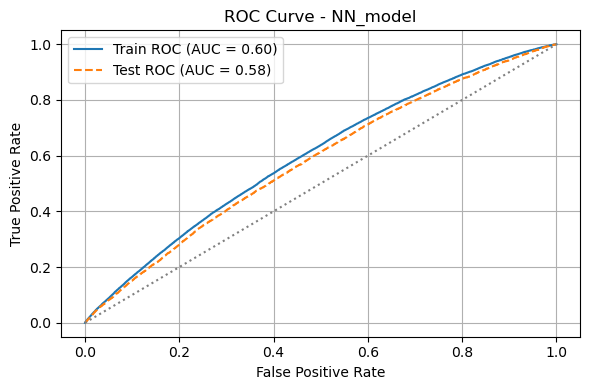

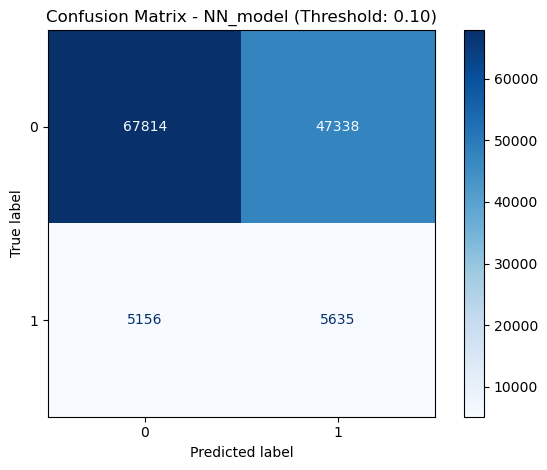

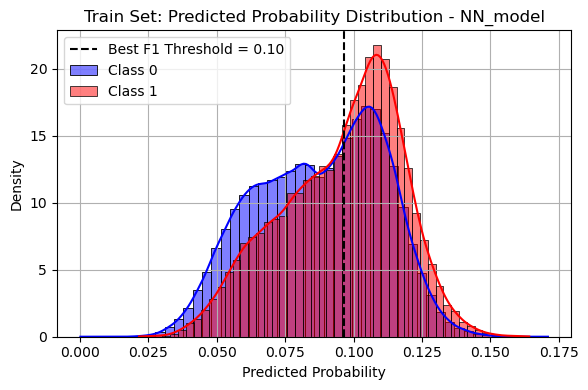

In [37]:
results_table = evaluate_model(nn_model, "NN_model", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [38]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6072,0.5820,0.7309,0.9156,0.9143,0.5261,0.1091,0.4524,0.1758
1,LGB,0.6066,0.5824,0.7189,0.9156,0.9143,0.5221,0.1091,0.4787,0.1777
2,CatBoost,0.5928,0.5857,0.6627,0.9156,0.9143,0.5181,0.1087,0.5029,0.1788
3,NN_model,0.5984,0.5801,0.1606,0.9156,0.9143,0.0964,0.1064,0.5222,0.1767


### REGRESJA LOGISTYCZNA

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

pos = np.sum(y_t == 1)
neg = np.sum(y_t == 0)
scale_pos_weight = neg / pos                       
class_weight = {0: 1.0, 1: scale_pos_weight}

log_reg = LogisticRegression(
    penalty="l2",
    C=1.0,
    solver="lbfgs",
    max_iter=1000,
    class_weight=class_weight,
    random_state=42
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t), 1):
    X_tr, X_val = X_t[train_idx], X_t[val_idx]
    y_tr, y_val = y_t[train_idx], y_t[val_idx]

    log_reg.fit(X_tr, y_tr)

    tr_auc  = roc_auc_score(y_tr,  log_reg.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, log_reg.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} — Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:      {:.4f}".format(np.mean(train_aucs)))
print("Average Validation AUC: {:.4f}".format(np.mean(val_aucs)))



Fold 1 — Train AUC: 0.5909, Validation AUC: 0.5873
Fold 2 — Train AUC: 0.5912, Validation AUC: 0.5856
Fold 3 — Train AUC: 0.5906, Validation AUC: 0.5879
Fold 4 — Train AUC: 0.5908, Validation AUC: 0.5877
Fold 5 — Train AUC: 0.5918, Validation AUC: 0.5835

Average Train AUC:      0.5911
Average Validation AUC: 0.5864


y_train
False
y_trai_pred
False

✅ Evaluation for logistic_regression
AUC - Train: 0.5906, Test: 0.5833
Best Accuracy Threshold: 0.90 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.51 | Precision: 0.1085, Recall: 0.5073, F1: 0.1787


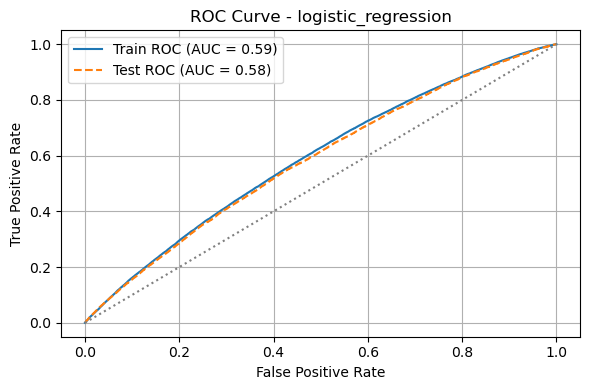

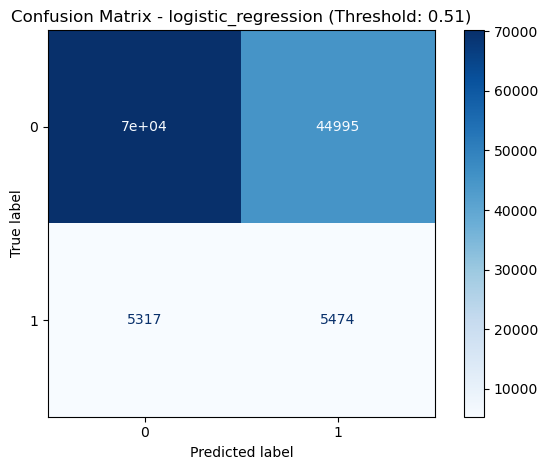

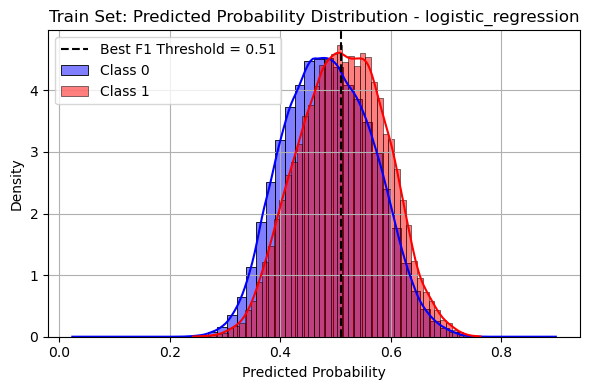

In [41]:
results_table = evaluate_model(log_reg, "logistic_regression", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [42]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6072,0.5820,0.7309,0.9156,0.9143,0.5261,0.1091,0.4524,0.1758
1,LGB,0.6066,0.5824,0.7189,0.9156,0.9143,0.5221,0.1091,0.4787,0.1777
2,CatBoost,0.5928,0.5857,0.6627,0.9156,0.9143,0.5181,0.1087,0.5029,0.1788
3,NN_model,0.5984,0.5801,0.1606,0.9156,0.9143,0.0964,0.1064,0.5222,0.1767
4,logistic_regression,0.5906,0.5833,0.8996,0.9156,0.9143,0.5100,0.1085,0.5073,0.1787


In [44]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

pos = np.sum(y_t == 1)
neg = np.sum(y_t == 0)
class_weight = {0: 1.0, 1: neg / pos}

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    class_weight=class_weight,
    random_state=42,
    n_jobs=-1
)

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
train_aucs, val_aucs = [], []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_t, y_t), 1):
    X_tr, X_val = X_t[train_idx], X_t[val_idx]
    y_tr, y_val = y_t[train_idx], y_t[val_idx]

    rf.fit(X_tr, y_tr)

    tr_auc = roc_auc_score(y_tr, rf.predict_proba(X_tr)[:, 1])
    val_auc = roc_auc_score(y_val, rf.predict_proba(X_val)[:, 1])

    print(f"Fold {fold} — Train AUC: {tr_auc:.4f}, Validation AUC: {val_auc:.4f}")
    train_aucs.append(tr_auc)
    val_aucs.append(val_auc)

print("\nAverage Train AUC:      {:.4f}".format(np.mean(train_aucs)))
print("Average Validation AUC: {:.4f}".format(np.mean(val_aucs)))


Fold 1 — Train AUC: 0.5966, Validation AUC: 0.5831
Fold 2 — Train AUC: 0.5964, Validation AUC: 0.5786
Fold 3 — Train AUC: 0.5975, Validation AUC: 0.5825
Fold 4 — Train AUC: 0.5968, Validation AUC: 0.5837
Fold 5 — Train AUC: 0.5951, Validation AUC: 0.5766

Average Train AUC:      0.5965
Average Validation AUC: 0.5809


y_train
False
y_trai_pred
False

✅ Evaluation for random forest
AUC - Train: 0.5927, Test: 0.5783
Best Accuracy Threshold: 0.57 | Train Acc: 0.9156, Test Acc: 0.9143
Best F1 Threshold: 0.51 | Precision: 0.1062, Recall: 0.5057, F1: 0.1755


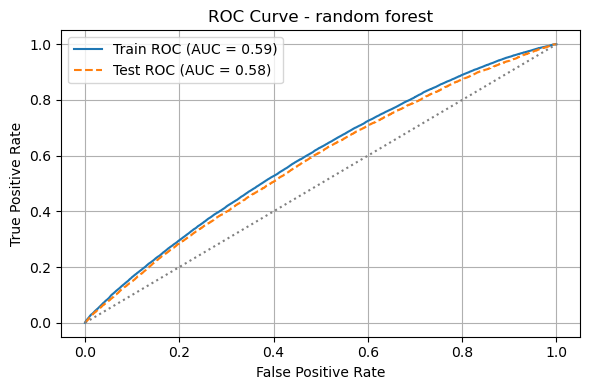

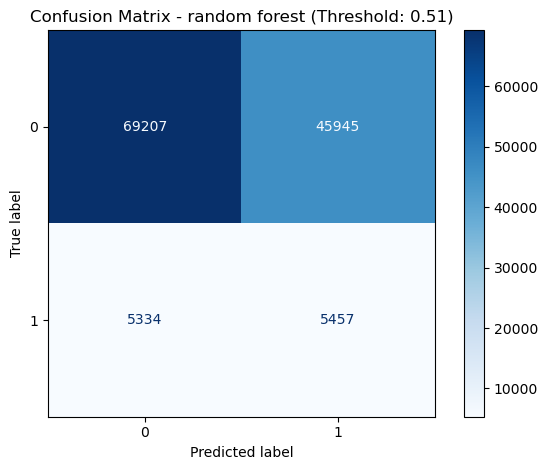

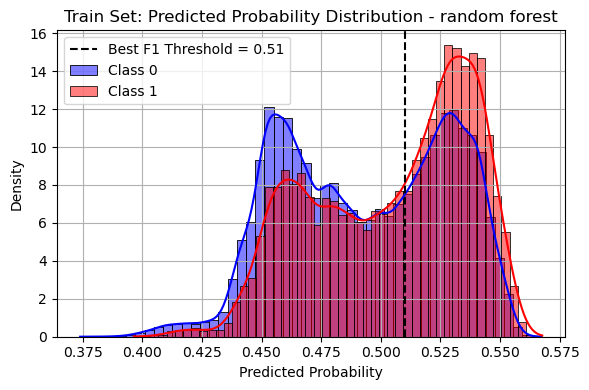

In [45]:
results_table = evaluate_model(rf, "random forest", X_t, y_t, X_tes, y_tes, results_df=results_table)

In [46]:
results_table

,model_name,train_auc,test_auc,best_threshold_acc,train_accuracy,test_accuracy,best_threshold_f1,precision,sensitivity,f1_score
0,XGBoost,0.6072,0.5820,0.7309,0.9156,0.9143,0.5261,0.1091,0.4524,0.1758
1,LGB,0.6066,0.5824,0.7189,0.9156,0.9143,0.5221,0.1091,0.4787,0.1777
2,CatBoost,0.5928,0.5857,0.6627,0.9156,0.9143,0.5181,0.1087,0.5029,0.1788
3,NN_model,0.5984,0.5801,0.1606,0.9156,0.9143,0.0964,0.1064,0.5222,0.1767
4,logistic_regression,0.5906,0.5833,0.8996,0.9156,0.9143,0.5100,0.1085,0.5073,0.1787
5,random forest,0.5927,0.5783,0.5663,0.9156,0.9143,0.5100,0.1062,0.5057,0.1755


### explaining model analysis:

In [49]:
fi = catboost_model.get_feature_importance(type='FeatureImportance')
fi_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': fi
}).sort_values('importance', ascending=False)
print("Feature Importance:")
fi_df.head(20)

Feature Importance:


,feature,importance
139,bad_rate,61.155864
12,risk_score,11.764327
27,countries_same,3.734926
1,is_international,3.363396
8,has_fraud_history,1.859845
21,speed_kmph,1.072531
2,session_length_seconds,0.997448
4,trust_score,0.978935
24,amount/sum_monthly_expenses,0.977788
19,time_diff_hours,0.962473


In [52]:
import shap

c:\Users\Jan\anaconda3\envs\mastercard\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Shap values plot

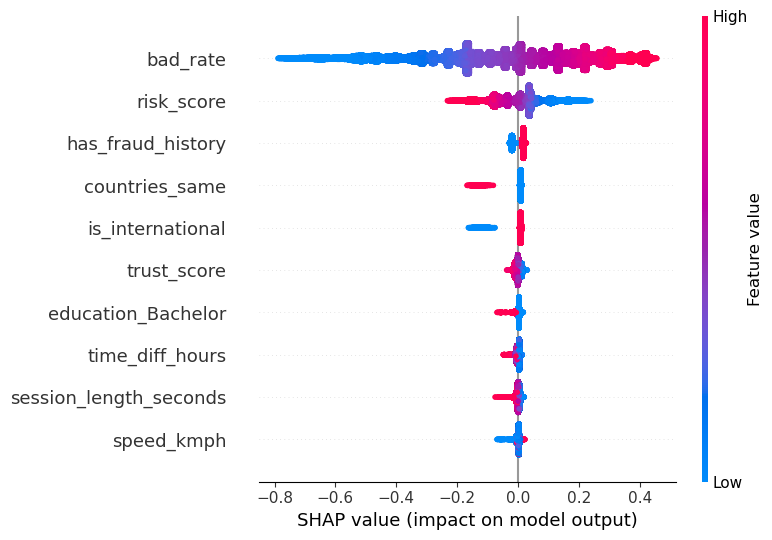

In [59]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, max_display=10)

In [62]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay


Partial Dependence

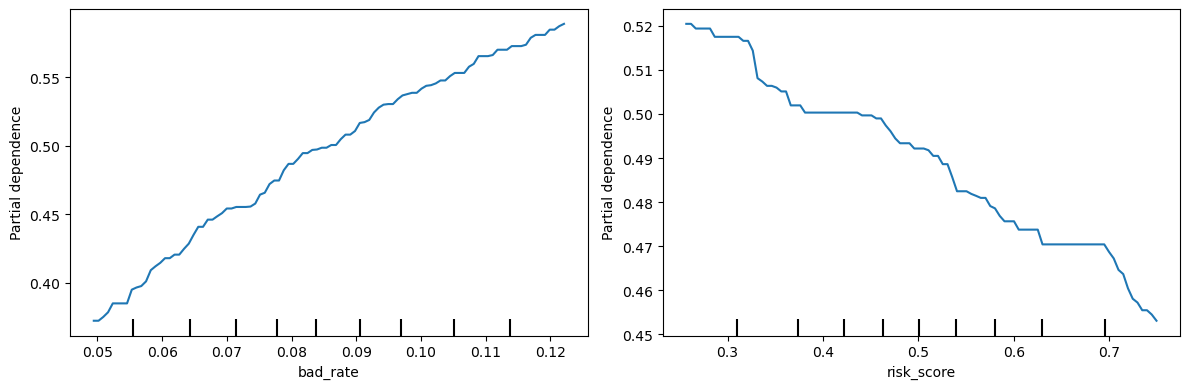

In [63]:
top_features = fi_df['feature'].head(2).tolist()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for i, feat in enumerate(top_features):
    display = PartialDependenceDisplay.from_estimator(
        catboost_model,
        X_train,
        [feat],
        ax=axes[i]
    )
plt.tight_layout()
plt.show()

Permutation Importance

In [66]:
test_result = permutation_importance(
    catboost_model,
    X_train,
    y_train,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance_mean': test_result.importances_mean,
    'importance_std': test_result.importances_std
}).sort_values('importance_mean', ascending=False)
print("\nPermutation Importance:")
perm_df.head(10)


Permutation Importance:


,feature,importance_mean,importance_std
139,bad_rate,0.014762,0.000469
12,risk_score,0.001653,0.000351
2,session_length_seconds,0.000219,0.000145
13,is_country_nan,0.000152,0.000061
4,trust_score,0.000151,0.000093
61,sex_Female,0.000125,0.000029
7,account_age_months,0.000117,0.000031
35,device_iOS,0.000104,0.000055
0,amount,0.000104,0.000060
31,channel_mobile,0.000095,0.000047


In [65]:
perm_df.tail(10)

,feature,importance_mean,importance_std
11,sum_of_monthly_expenses,-0.000067,0.000069
34,device_Web,-0.000072,0.000039
10,sum_of_monthly_installments,-0.000125,0.000036
6,avg_transaction_amount,-0.000172,0.000051
14,country_merchant_distance_centroid,-0.000184,0.000059
108,transaction_country_Germany,-0.000274,0.000041
24,amount/sum_monthly_expenses,-0.000365,0.000093
23,amount/sum_monthly_installments,-0.000609,0.000071
22,amount/avg_amount,-0.000609,0.000032
8,has_fraud_history,-0.002453,0.000082
